<span style="color:cyan; font-size:40px">Imports</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

<span style="color:cyan; font-size:40px">Κωδικοι απλα για χρωματα στο terminal</span>

In [2]:
class colors:
    RED = '\033[91m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    MAGENTA = '\033[95m'
    CYAN = '\033[96m'
    BOLD_RED = '\033[1m\033[91m'
    BOLD_GREEN = '\033[1m\033[92m'
    BOLD_YELLOW = '\033[1m\033[93m'
    BOLD_BLUE = '\033[1m\033[94m'
    BOLD_MAGENTA = '\033[1m\033[95m'
    BOLD_CYAN = '\033[1m\033[96m'
    END = '\033[0m'

<span style="color:cyan; font-size:40px">Φορτωση δεδομενων και δημιουργια dataframe</span>

In [3]:
data = np.load('Dataset.npy')

#Χωρισμος data
data_split = [item.split(',') for item in data]

#Αφαιρουμε τα prefix για να φαινονται πιο ομορφα
data_split = [[user[2:], movie[2:], rating, date] for user, movie, rating, date in data_split]

#Φτιαχνουμε το Dataframe
df_all_data = pd.DataFrame(data_split, columns=['UserID', 'MovieID', 'Rating', 'Date'])

#Μετατρεπουμε τους τυπους
df_all_data['UserID'] = df_all_data['UserID'].astype('int')
df_all_data['MovieID'] = df_all_data['MovieID'].astype('int')
df_all_data['Rating'] = df_all_data['Rating'].astype('int')
df_all_data['Date'] = pd.to_datetime(df_all_data['Date'], format="%d %B %Y", dayfirst=True)

<span style="color:cyan; font-size:40px">Βλεπουμε το dataframe</span>

In [4]:
df_all_data

,UserID,MovieID,Rating,Date
0,4592644,120884,10,2005-01-16
1,3174947,118688,3,2005-01-16
2,3780035,387887,8,2005-01-16
3,4592628,346491,1,2005-01-16
4,3174947,94721,8,2005-01-16
...,...,...,...,...
4669815,581842,107977,6,2005-01-16
4669816,3174947,103776,8,2005-01-16
4669817,4592639,107423,9,2005-01-16
4669818,4581944,102614,8,2005-01-16


<span style="color:cyan; font-size:40px">Βλεπουμε τους τυπους του dataframe</span>

In [5]:
df_all_data.dtypes

UserID              int32
MovieID             int32
Rating              int32
Date       datetime64[ns]
dtype: object

<span style="color:cyan; font-size:40px">Τσεκαρουμε αν υπαρχουν duplicate (ιδιος χρηστης σε ιδια ταινια)</span>

In [6]:
#Τα κανουμε group με βαση userID και movieID
rating_counts = df_all_data.groupby(['UserID', 'MovieID']).size().sort_values(ascending=False)

#Φιλτραρουμε αυτα που εχουν πανω απο 1 ιδιο
duplicate_ratings = rating_counts[rating_counts > 1]

#Βλεπουμε τα duplicate
duplicate_ratings

UserID     MovieID 
89246644   7784604     34
119385229  10350626    31
123084164  10350626    23
92389474   9110586     22
89320180   7784604     21
                       ..
300559     133093       2
97081342   478176       2
1801236    118749       2
115582678  10305992     2
1829504    41452        2
Length: 20529, dtype: int64

<span style="color:cyan; font-size:40px">Απο κατω βλεπουμε οτι πρεπει να αφαιρεθουν 22723 rows</span>

In [7]:
#Βρισκουμε το αθροισμα
total_duplicate_sum = duplicate_ratings.sum()

#Εκτυπωνουμε ποσα duplicate πρεπει να αφαιρεθουν, δεν ειναι 43.252 καθως πρεπει να κρατησουμε το 1 οχι να τα διωξουμε ολα
print(f"Total sum of all duplicate occurrences: {colors.RED+str(total_duplicate_sum)+colors.END}")
print(f"Total duplicates that we must remove: {colors.RED+str(total_duplicate_sum - len(duplicate_ratings))+colors.END}")

Total sum of all duplicate occurrences: 43252
Total duplicates that we must remove: 22723


<span style="color:cyan; font-size:40px"> Παραδειγμα για το μεγαλυτερο duplicate, βλεπουμε 34 rating στην ιδια ταινια</span>

In [8]:
#Βρισκουμε το μεγαλυτερο duplicate
first_index = duplicate_ratings.index[0]

#Παιρνουμε rating και ημερομηνια για να τα δουμε παρακατω
ratings_of_first_index = df_all_data[(df_all_data['UserID'] == first_index[0]) & (df_all_data['MovieID'] == first_index[1])]
ratings_and_dates_of_first_index = ratings_of_first_index[['Rating', 'Date']]

print(f"{colors.BOLD_BLUE}All ratings and dates of the first index:{colors.END}\n")
print(ratings_and_dates_of_first_index)


All ratings and dates of the first index:

         Rating       Date
2758402      10 2018-06-22
2758850      10 2018-06-23
2759140      10 2018-06-23
2759270      10 2018-06-23
2759858      10 2018-06-24
2760872      10 2018-06-25
2761373      10 2018-06-26
2761970      10 2018-06-26
2763971      10 2018-06-29
2765613      10 2018-07-01
2766011      10 2018-07-01
2767082      10 2018-07-02
2768722      10 2018-07-04
2772050      10 2018-07-07
2777040      10 2018-07-12
2809820      10 2018-08-09
2822995      10 2018-08-19
2828175      10 2018-08-22
2829970      10 2018-08-24
2832014      10 2018-08-25
2840427      10 2018-08-31
2842680      10 2018-09-01
2847270      10 2018-09-04
2865411      10 2018-09-17
2868731      10 2018-09-19
2896835      10 2018-10-07
2918335      10 2018-10-20
2948685      10 2018-11-09
2967079      10 2018-11-21
3030417      10 2018-12-31
3057105      10 2019-01-14
3161612      10 2019-03-15
3188099      10 2019-04-01
3328455      10 2019-06-10


<span style="color:cyan; font-size:40px">Βλεπουμε οτι εχουμε duplicate χρηστων σε ιδιες ταινιες απο 1 εως 33 φορες οποτε θα κρατησουμε μονο την τελευταια</span>

In [9]:
#Κραταμε το τελευταιο index
latest_indices = df_all_data.groupby(['UserID', 'MovieID'])['Date'].idxmax()

#Φτιαχνουμε νεο dataframe με βαση αυτα
df_all_data_new = df_all_data.loc[latest_indices]

#Κανουμε reset τα index στο νεο dataframe αφου διωξαμε τα παλια ratings
df_all_data_new.reset_index(drop=True, inplace=True)


<span style="color:cyan; font-size:40px">Απο κατω βλεπουμε οτι αφαιρεθηκαν σωστα 22.723 rows</span>

In [10]:
num_duplicates_old = df_all_data.duplicated().sum()
num_duplicates_new = df_all_data_new.duplicated().sum()

print(f"Number of duplicate rows in the old dataframe: {colors.RED+str(num_duplicates_old)+colors.END} ---- Total dataframe rows: {colors.RED+str(len(df_all_data))+colors.END}")
print(f"Number of duplicate rows in the new dataframe: {colors.RED+str(num_duplicates_new)+colors.END} ---- Total dataframe rows: {colors.RED+str(len(df_all_data_new))+colors.END}")
print(f"{colors.BOLD_GREEN}Total rows deleted: {str(len(df_all_data)-len(df_all_data_new))+colors.END}")

Number of duplicate rows in the old dataframe: 9382 ---- Total dataframe rows: 4669820
Number of duplicate rows in the new dataframe: 0 ---- Total dataframe rows: 4647097
Total rows deleted: 22723


<span style="color:red; font-size:60px">Προ-επεξεργασία Δεδομένων</span>



<span style="color:blue; font-size:50px">Ερώτημα 1</span>

In [11]:
#Κραταμε τους μοναδικους χρηστες και ταινιες και φτιαχνουμε 2 καινουρια dataframe γιαυτα τα 2
unique_users = df_all_data['UserID'].unique()
unique_movies = df_all_data['MovieID'].unique()

df_unique_users = pd.DataFrame(unique_users, columns=['UniqueUserID'])
df_unique_movies = pd.DataFrame(unique_movies, columns=['UniqueMovieID'])

In [12]:
#Debug print
df_unique_users.head()

,UniqueUserID
0,4592644
1,3174947
2,3780035
3,4592628
4,1162550


In [13]:
#Debug print
df_unique_movies.head()

,UniqueMovieID
0,120884
1,118688
2,387887
3,346491
4,94721


In [14]:
print(f"{colors.GREEN}Length of all users: {colors.BOLD_GREEN+str(len(df_all_data.iloc[:, 0]))+colors.GREEN}, Length of unique users U: {colors.BOLD_GREEN+str(len((df_unique_users)))+colors.GREEN}")
print(f"{colors.GREEN}Length of all movies: {colors.BOLD_GREEN+str(len(df_all_data.iloc[:, 1]))+colors.GREEN}, Length of unique movies I: {colors.BOLD_GREEN+str(len((df_unique_movies)))+colors.END}")

Length of all users: 4669820, Length of unique users U: 1499238
Length of all movies: 4669820, Length of unique movies I: 351109


<span style="color:blue; font-size:50px">Ερώτημα 2</span>

<span style="color:cyan; font-size:40px">Βρισκουμε που κυμαινεται ο αριθμος των αξιολογησεων</span>

In [15]:
user_rating_counts = df_all_data.groupby('UserID').size()

#Τα κανουμε sort για να δουμε περιπου τι τιμες εχουμε και τι τιμες θα παρουμε
sorted_user_rating_counts = user_rating_counts.sort_values(ascending=False)

print(sorted_user_rating_counts)


UserID
2467618      24145
20552756     16817
2483625      16715
482513       13213
2898520      12677
             ...  
23252608         1
23252585         1
23252584         1
23252533         1
126872318        1
Length: 1499238, dtype: int64


<span style="color:cyan; font-size:40px">Περιορισαμε τους χρηστες αναλογα το ποσες αξιολογησεις εχουν κανει</span>

In [16]:
filtered_user_rating_counts = user_rating_counts[(user_rating_counts > 1000) & (user_rating_counts < 2000)]

print(f"{colors.GREEN}Users remaining: {str(len(filtered_user_rating_counts))+colors.END}")
filtered_user_rating_counts

Users remaining: 140


UserID
11762        1655
70535        1156
102677       1109
102816       1635
178741       1187
             ... 
67430579     1453
79950921     1013
89333699     1002
94289145     1106
104603847    1683
Length: 140, dtype: int64

<span style="color:cyan; font-size:40px">Κρατησαμε μονο 140 χρηστες αλλα εχουμε σχεδον 200000 Ratings</span>

In [17]:
#Φιλτραρουμε τους χρηστες μονο σε αυτους που πληρουν τα κριτηρια
df_filtered_users = df_all_data[df_all_data['UserID'].isin(filtered_user_rating_counts.index)]

#Τα κανουμε και ενα sort με userID για να δω οτι ειναι ιδια με τα απο πανω
df_filtered_users_sorted = df_filtered_users.sort_values(by='UserID')
df_filtered_users_sorted


,UserID,MovieID,Rating,Date
2915231,11762,167260,8,2018-10-19
3520157,11762,2235108,7,2019-10-03
2373413,11762,116778,3,2017-04-20
3520152,11762,442268,8,2019-10-03
1175371,11762,887883,2,2010-05-10
...,...,...,...,...
3401731,104603847,268126,2,2019-07-24
3352229,104603847,480687,6,2019-06-24
3352227,104603847,910936,10,2019-06-24
3352240,104603847,1139797,7,2019-06-24


<span style="color:blue; font-size:50px">Ερώτημα 3</span>

In [18]:
#Βλεπουμε ποσοι χρηστες εχουν 1 αξιολογηση και ποσοι παραπανω
num_users_with_one_rating = (user_rating_counts == 1).sum()
num_users_with_more_than_one_rating = (user_rating_counts > 1).sum()

# Print the results
print(f"{colors.GREEN}Number of users with only one rating: {colors.BOLD_GREEN+str(num_users_with_one_rating)}")
print(f"{colors.GREEN}Number of users with more than one rating: {colors.BOLD_GREEN+str(num_users_with_more_than_one_rating)}")


Number of users with only one rating: 1069533
Number of users with more than one rating: 429705


<span style="color:cyan; font-size:40px">Ιστογραμματα για ολους τους χρηστες</span>

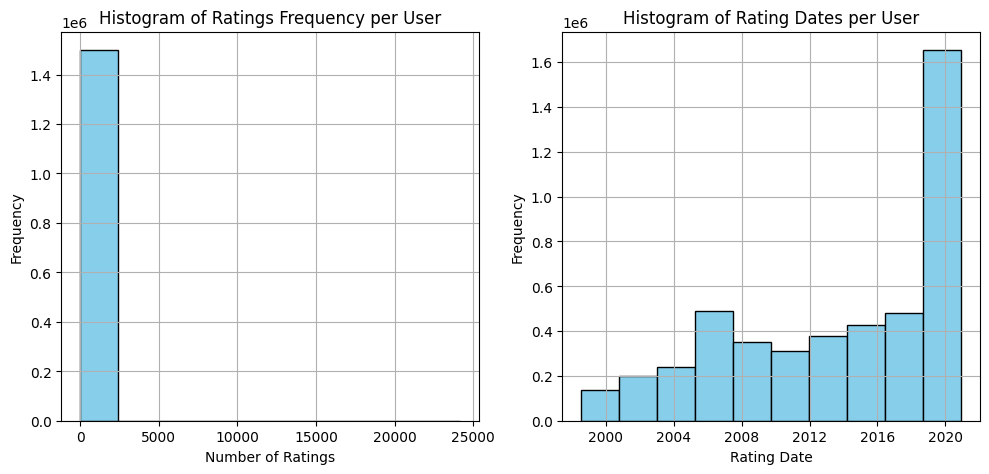

In [19]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(user_rating_counts.values, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Ratings Frequency per User')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(df_all_data['Date'], color='skyblue', edgecolor='black')
axs[1].set_title('Histogram of Rating Dates per User')
axs[1].set_xlabel('Rating Date')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

<span style="color:cyan; font-size:40px">Ιστογραμματα για τους περιορισμενους χρηστες</span>

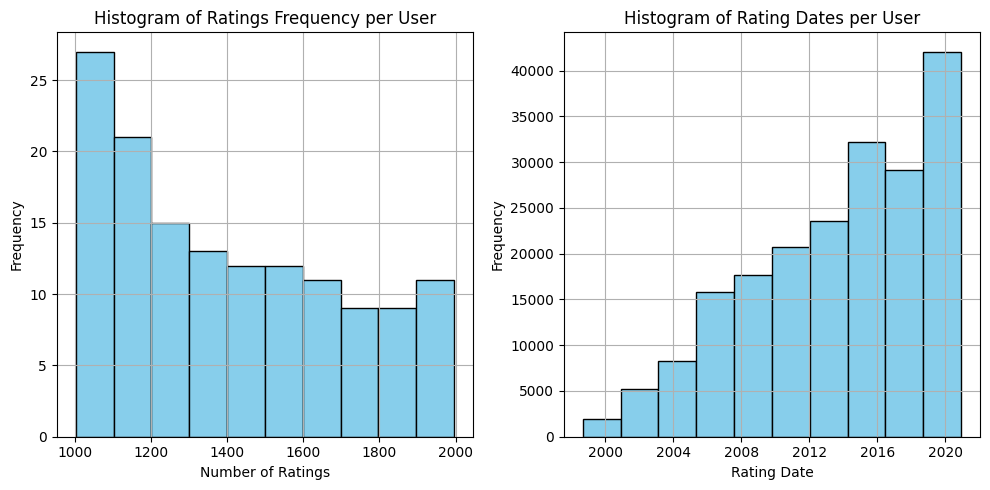

In [20]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))

axs[0].hist(filtered_user_rating_counts.values, color='skyblue', edgecolor='black')
axs[0].set_title('Histogram of Ratings Frequency per User')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

axs[1].hist(df_filtered_users['Date'], color='skyblue', edgecolor='black')
axs[1].set_title('Histogram of Rating Dates per User')
axs[1].set_xlabel('Rating Date')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

plt.tight_layout()
plt.show()

<span style="color:blue; font-size:50px">Ερώτημα 4</span>

<span style="color:cyan; font-size:40px">Δημιουργησαμε Dataframe με column names το movieID και row names το userID</span>

In [21]:
#Φτιαχνω ενα νεο dataframe που θα εχω τα data μου (users , movies)
user_ids = sorted(df_filtered_users['UserID'].unique())
movie_ids = sorted(df_filtered_users['MovieID'].unique())

df_users_movies = pd.DataFrame(0, index=user_ids, columns=movie_ids).astype('int')

#Για ονομα τιτλων των row και column εχουμε δωσει το ID των users και movies αντιστοιχα
for index, row in df_filtered_users.iterrows():
    user_id = row['UserID']
    movie_id = row['MovieID']
    rating = row['Rating']
    
    if rating > 0:
        df_users_movies.at[user_id, movie_id] = rating

#Debug print
df_users_movies

,1,3,5,10,12,14,41,49,75,91,...,13540912,13540914,13540918,13540920,13556386,13563016,13563480,13566084,13566090,13576114
11762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
70535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102677,0,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102816,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
178741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67430579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79950921,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
89333699,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94289145,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<span style="color:cyan; font-size:40px">Παραδειγμα για να τσεκαρουμε οτι εγινε σωστα</span>

In [22]:
user_id = 562732
user_data = df_all_data[df_all_data['UserID'] == user_id]
print(df_users_movies.iloc[2, 2])

5


<span style="color:red; font-size:60px">Αλγοριθμοι Ομαδοποιησης Δεδομενων</span>



<span style="color:blue; font-size:50px">Ερώτημα 1</span>

<span style="color:yellow; font-size:50px">Υποερώτημα 1a-1b</span>

<span style="color:cyan; font-size:40px">Υπολογιζουμε τις 2 μετρικες σε ξεχωριστα function και βγαζουμε τα distance matrix</span>

In [23]:
#Συναρτηση για την 1η μετρικη
def custom_euclidean_distance(Ru, Rv, lambdas_u, lambdas_v):
    common_indices = np.where((lambdas_u == 1) & (lambdas_v == 1))[0]
    distance = np.sqrt(np.sum((np.array(Ru)[common_indices] - np.array(Rv)[common_indices])**2))
    
    return distance

#Συναρτηση για την 2η μετρικη
def dist_cosine(Ru, Rv, lambda_u, lambda_v):
    common_indices = np.where((lambda_u == 1) & (lambda_v == 1))[0]
    Ru_common, Rv_common = Ru[common_indices], Rv[common_indices]
    lambda_u_common, lambda_v_common = lambda_u[common_indices], lambda_v[common_indices]
    numerator = np.sum(Ru_common * Rv_common * lambda_u_common * lambda_v_common)
    denominator = np.sqrt(np.sum(np.square(Ru_common) * lambda_u_common * lambda_v_common)) * np.sqrt(np.sum(np.square(Rv_common) * lambda_u_common * lambda_v_common))
    
    return 1 - (numerator / max(denominator, 1e-10))

num_vectors = len(df_users_movies)

#Φτιαχνουμε τους 2 πινακες αποστασεων ξεχωριστα
distances = np.zeros((num_vectors, num_vectors))
distances2 = np.zeros((num_vectors, num_vectors))

#Περναω τα ζευγαρια και υπολογιζω τους πινακες
for i in range(len(df_users_movies)):
    for j in range(i + 1, len(df_users_movies)):
        Ru = df_users_movies.iloc[i].values
        Rv = df_users_movies.iloc[j].values
        lambdas_u = np.where(np.logical_and(Ru > 0, Rv > 0), 1, 0)
        lambdas_v = np.where(np.logical_and(Ru > 0, Rv > 0), 1, 0)

        distance = custom_euclidean_distance(Ru, Rv, lambdas_u, lambdas_v)
        distance2 = dist_cosine(Ru, Rv, lambdas_u, lambdas_v)
        
        distances[i, j] = distance
        #Αντιστοιχα για το συμμετικο του
        distances[j, i] = distance

        distances2[i, j] = distance2
        #Αντιστοιχα για το συμμετικο του
        distances2[j, i] = distance2



<span style="color:yellow; font-size:50px">Υποερώτημα 1c</span>

<span style="color:cyan; font-size:40px">K-means με custom_euclidean_distance(1-10 clusters)</span>

c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its 

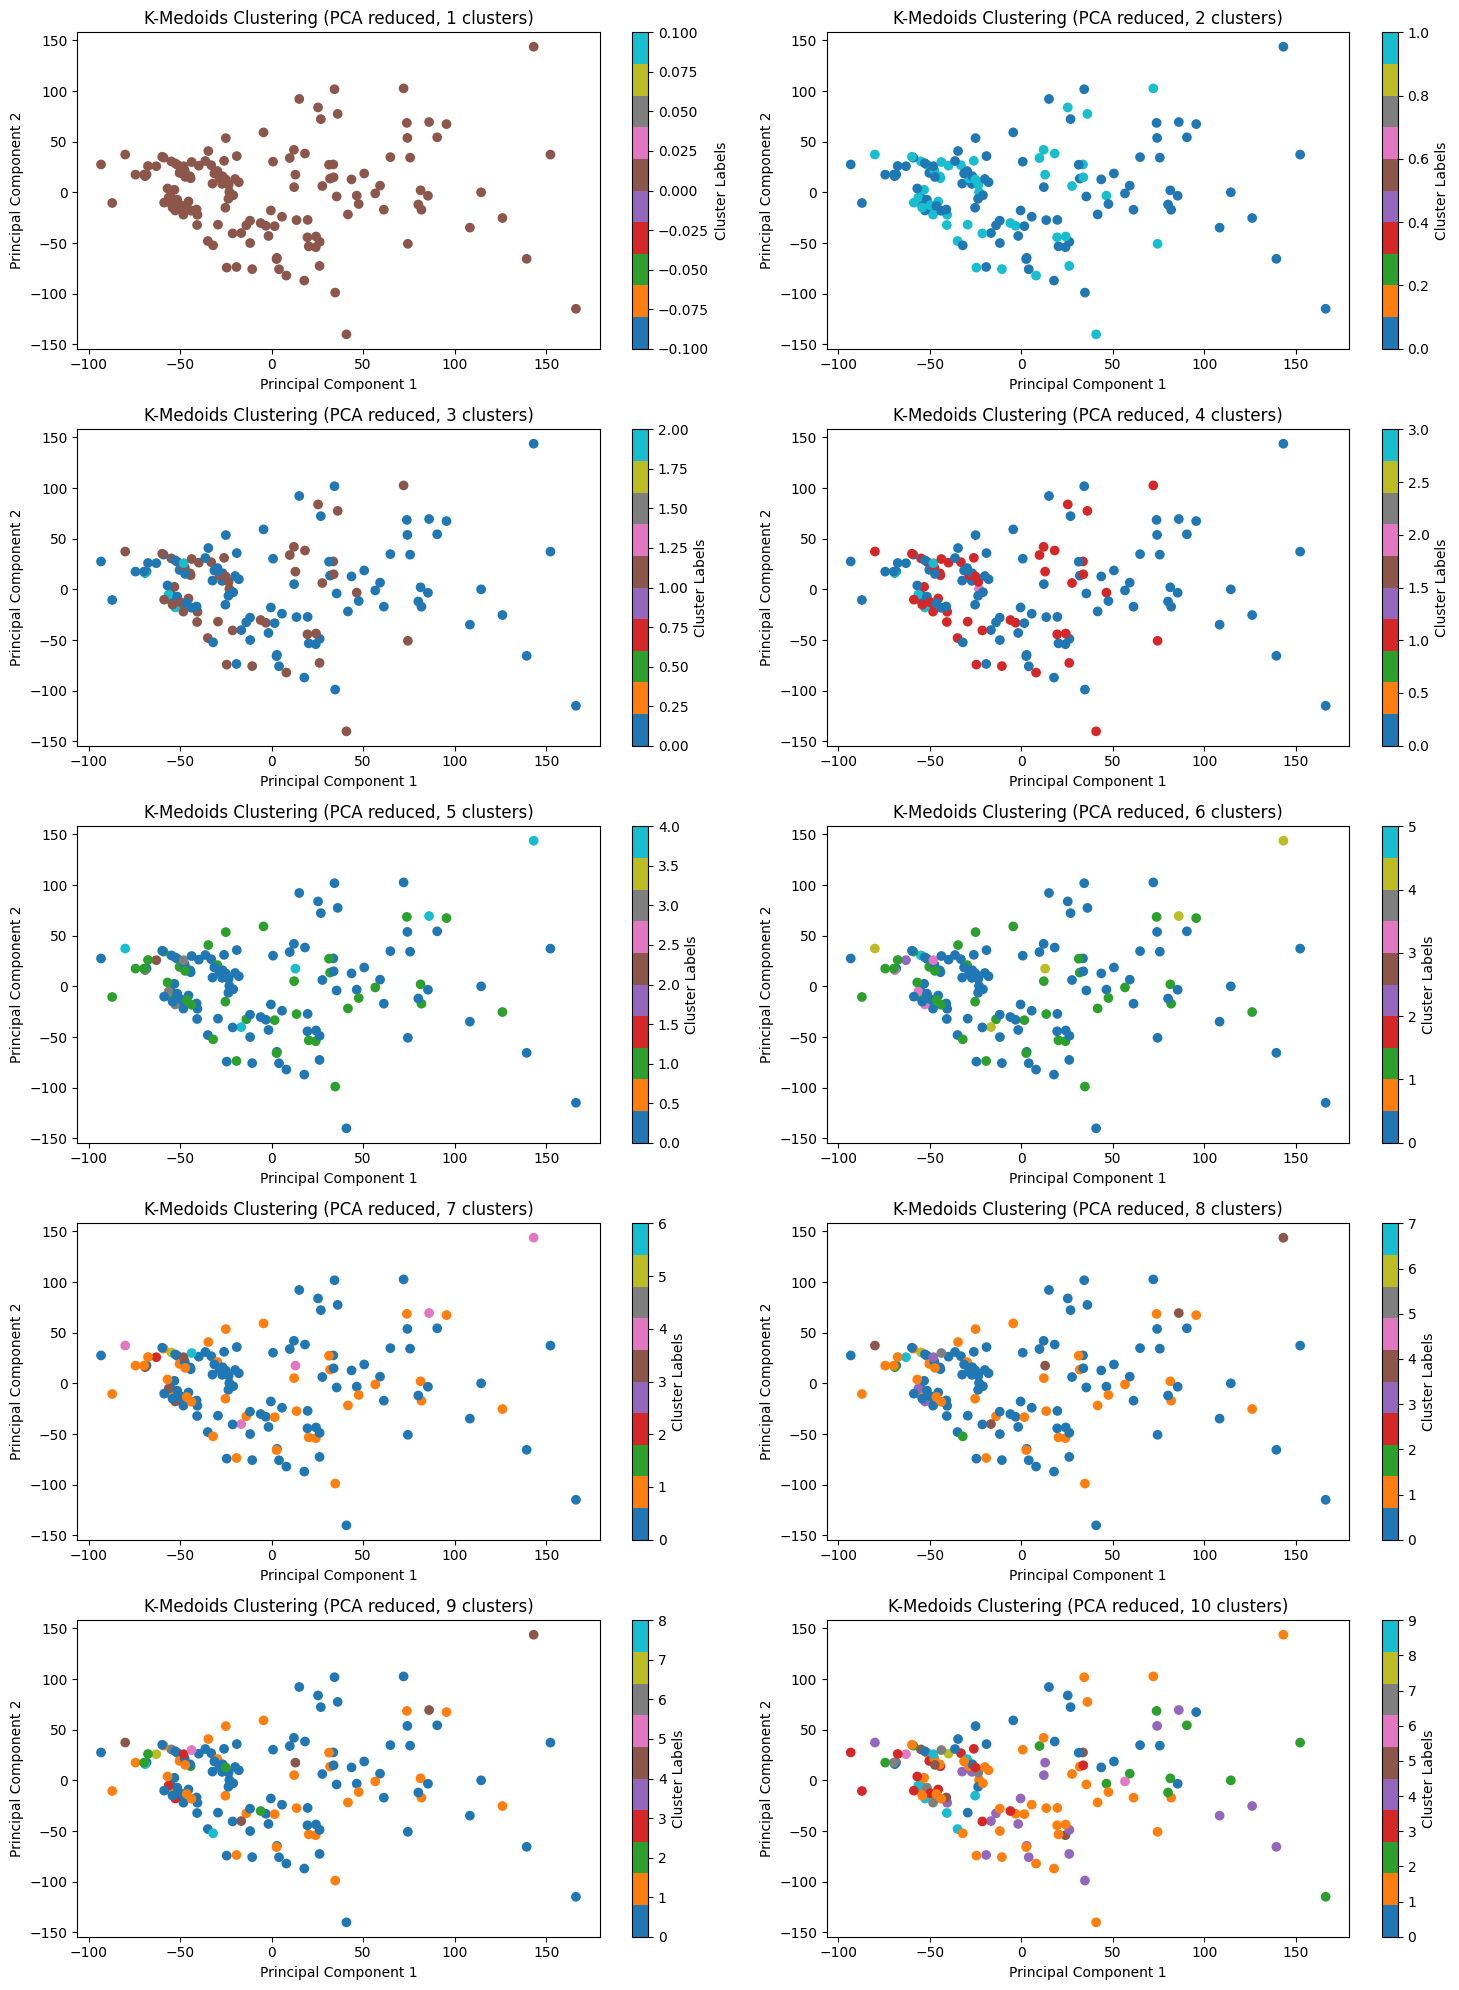

In [24]:
#PCA για να το ελαττωσουμε σε 2 διαστασεις ωστε να το προβαλλουμε
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_users_movies)

#subplot 5x2 για να τα δειξουμε ολα σε ενα figure
fig, axs = plt.subplots(5, 2, figsize=(15, 20))

#Δοκιμαζουμε απο 1 μεχρι 10 clusters
for i in range(1, 11):
    #Χρησιμοποιησαμε KMedoids στο οποιο μας αφηνει να χρησιμοποιησουμε αποστασεις αντι για τα δεδομενα με τον παρακατω τροπο
    kmedoids = KMedoids(n_clusters=i, metric='precomputed', random_state=1)
    #Για τις αποστασεις της custom Ευκλιδειας πρωτα
    kmedoids.fit(distances)
    clusters = kmedoids.labels_
    
    scatter = axs[(i-1) // 2, (i-1) % 2].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='tab10')
    
    cbar = fig.colorbar(scatter, ax=axs[(i-1) // 2, (i-1) % 2])
    cbar.set_label('Cluster Labels')
    
    axs[(i-1) // 2, (i-1) % 2].set_title('K-Medoids Clustering (PCA reduced, ' + str(i) + ' clusters)')
    axs[(i-1) // 2, (i-1) % 2].set_xlabel('Principal Component 1')
    axs[(i-1) // 2, (i-1) % 2].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

<span style="color:cyan; font-size:40px">Elbow μεθοδος για να δουμε τον ιδανικο αριθμο clusters</span>

c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 6 is empty! self.labels_[self.medoid_indices_[6]] may not be labeled with its corresponding cluster (6).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its corresponding cluster (5).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 7 is empty! self.labels_[self.medoid_indices_[7]] may not be labeled with its corresponding cluster (7).
  warnings.warn(
c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:329: UserWarning: Cluster 5 is empty! self.labels_[self.medoid_indices_[5]] may not be labeled with its 

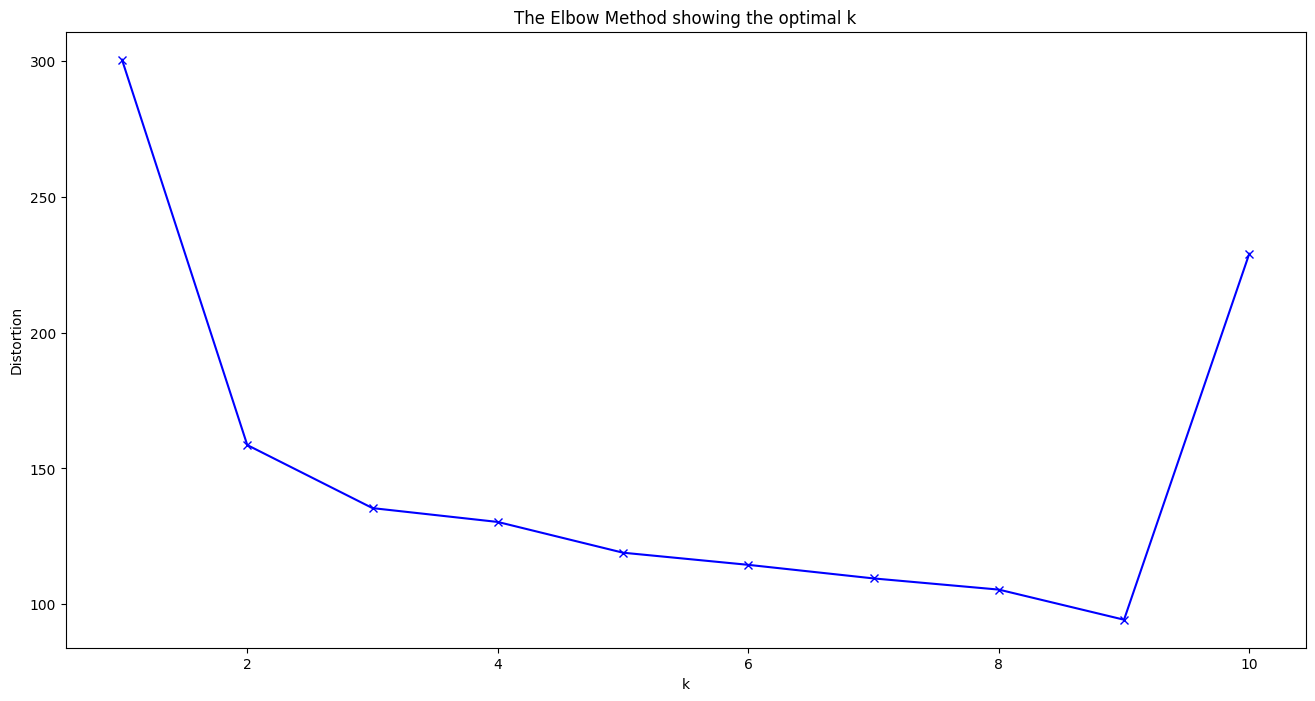

In [25]:
distortions = []
K = range(1, 11)

for k in K:
    kmedoidModel = KMedoids(n_clusters=k, metric='precomputed', random_state=1)
    kmedoidModel.fit(distances)
    distortions.append(kmedoidModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<span style="color:cyan; font-size:40px">K-means με distCosine(1-10 clusters)</span>

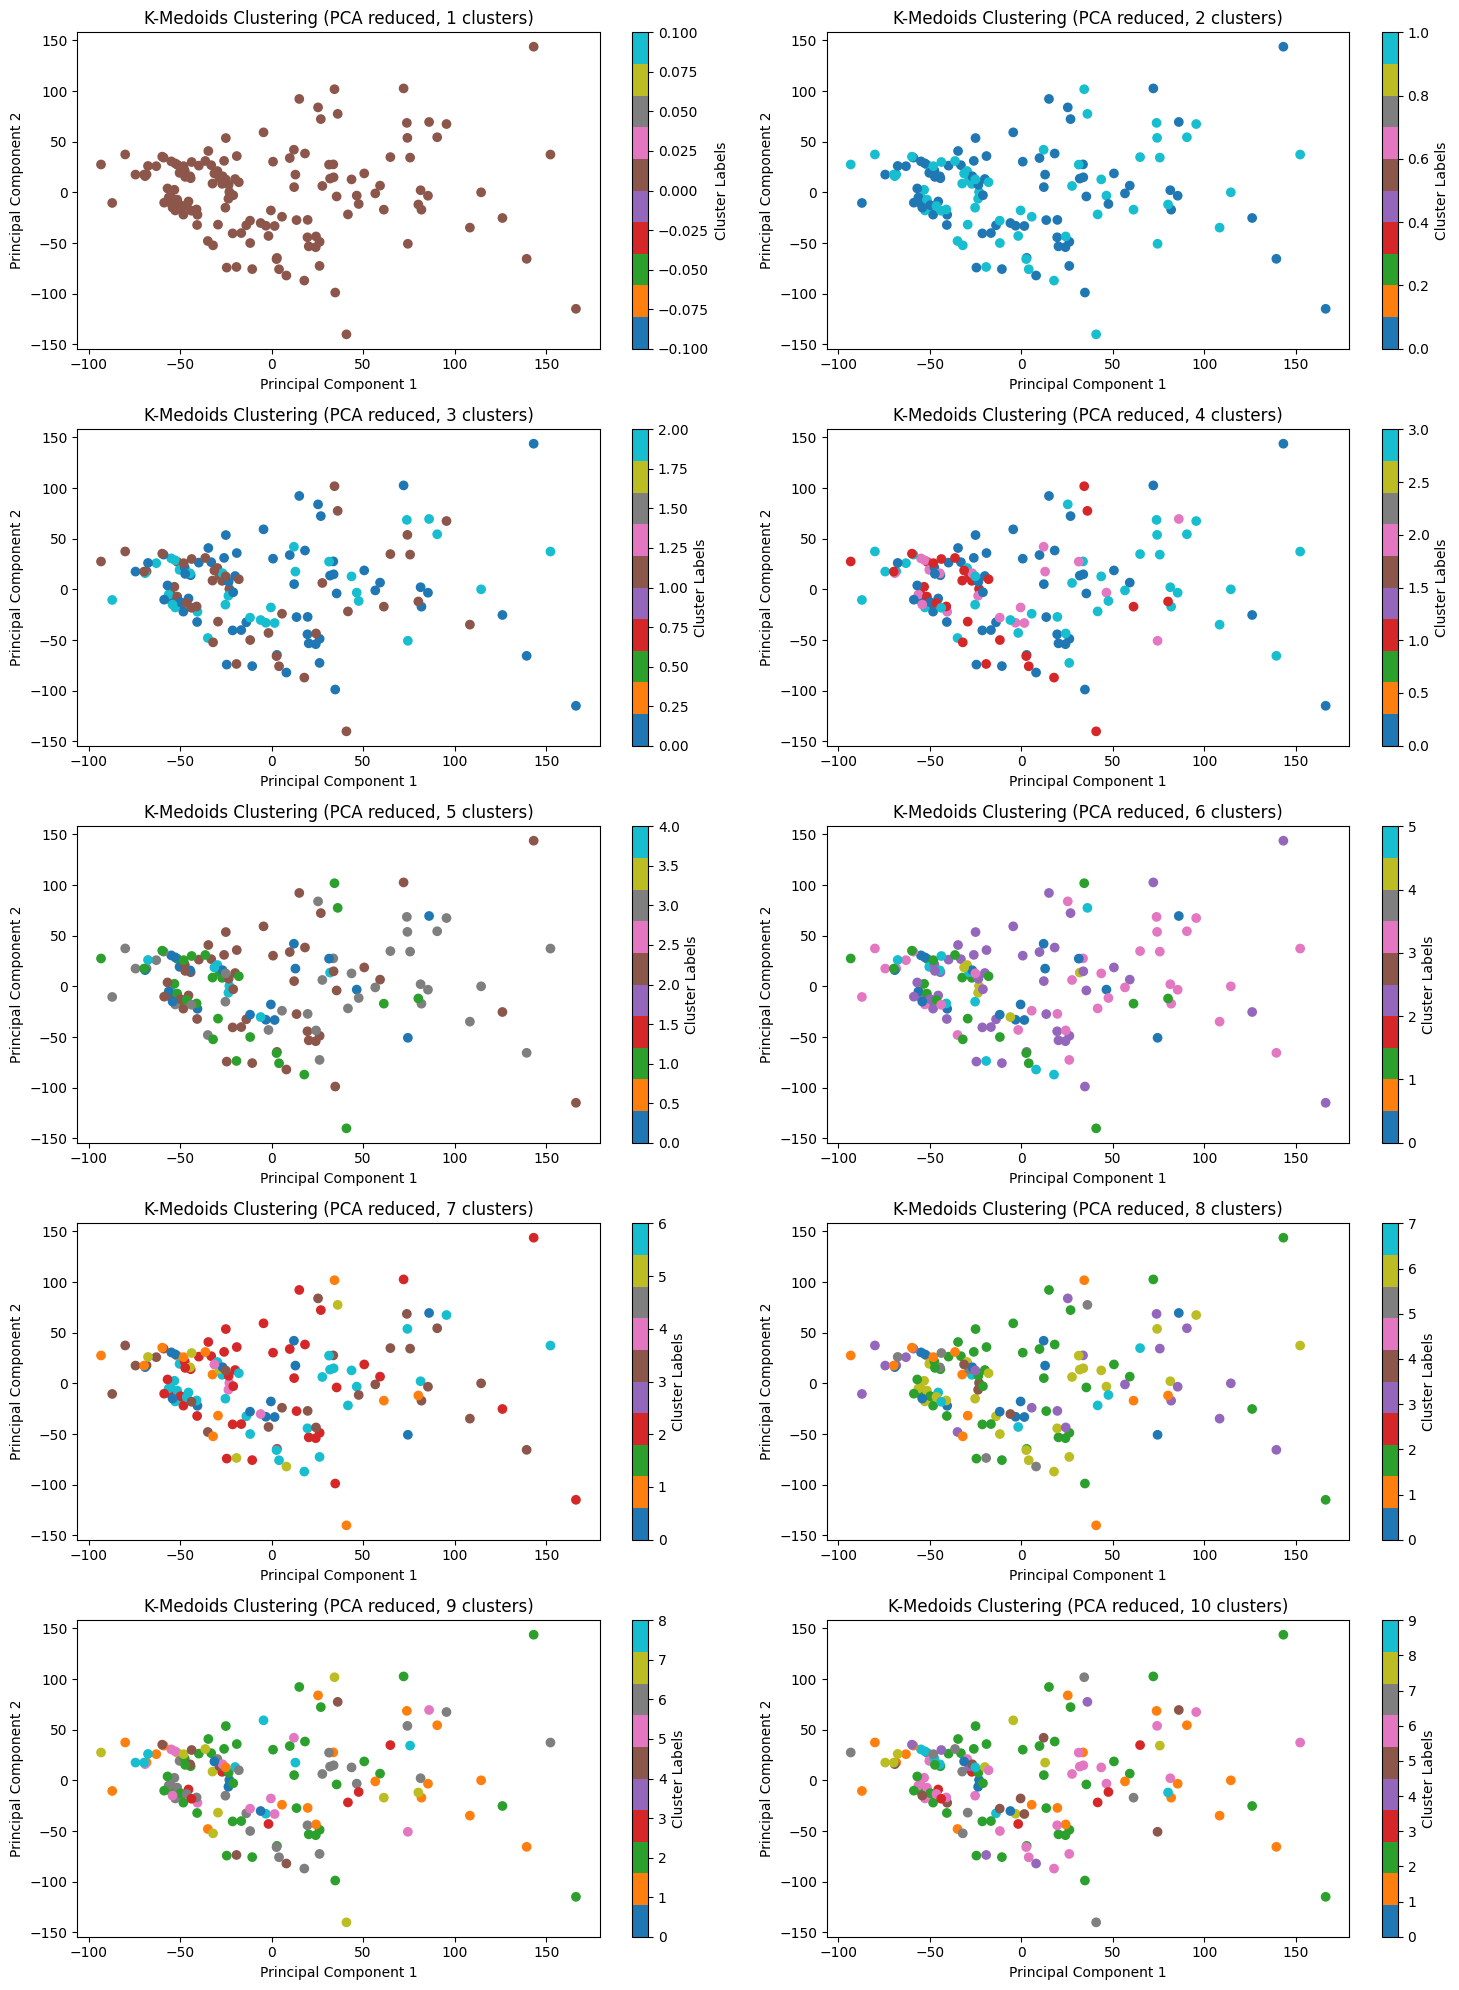

In [26]:
#Ιδιο με το παραπανω απλα για τον αλλο πινακα αποστασεων με το distCosine
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_users_movies)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, metric='precomputed', random_state=1)
    kmedoids.fit(distances2)
    clusters = kmedoids.labels_
    
    scatter = axs[(i-1) // 2, (i-1) % 2].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='tab10')
    
    cbar = fig.colorbar(scatter, ax=axs[(i-1) // 2, (i-1) % 2])
    cbar.set_label('Cluster Labels')
    
    axs[(i-1) // 2, (i-1) % 2].set_title('K-Medoids Clustering (PCA reduced, ' + str(i) + ' clusters)')
    axs[(i-1) // 2, (i-1) % 2].set_xlabel('Principal Component 1')
    axs[(i-1) // 2, (i-1) % 2].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

<span style="color:cyan; font-size:40px">Elbow μεθοδος για να δουμε τον ιδανικο αριθμο clusters</span>

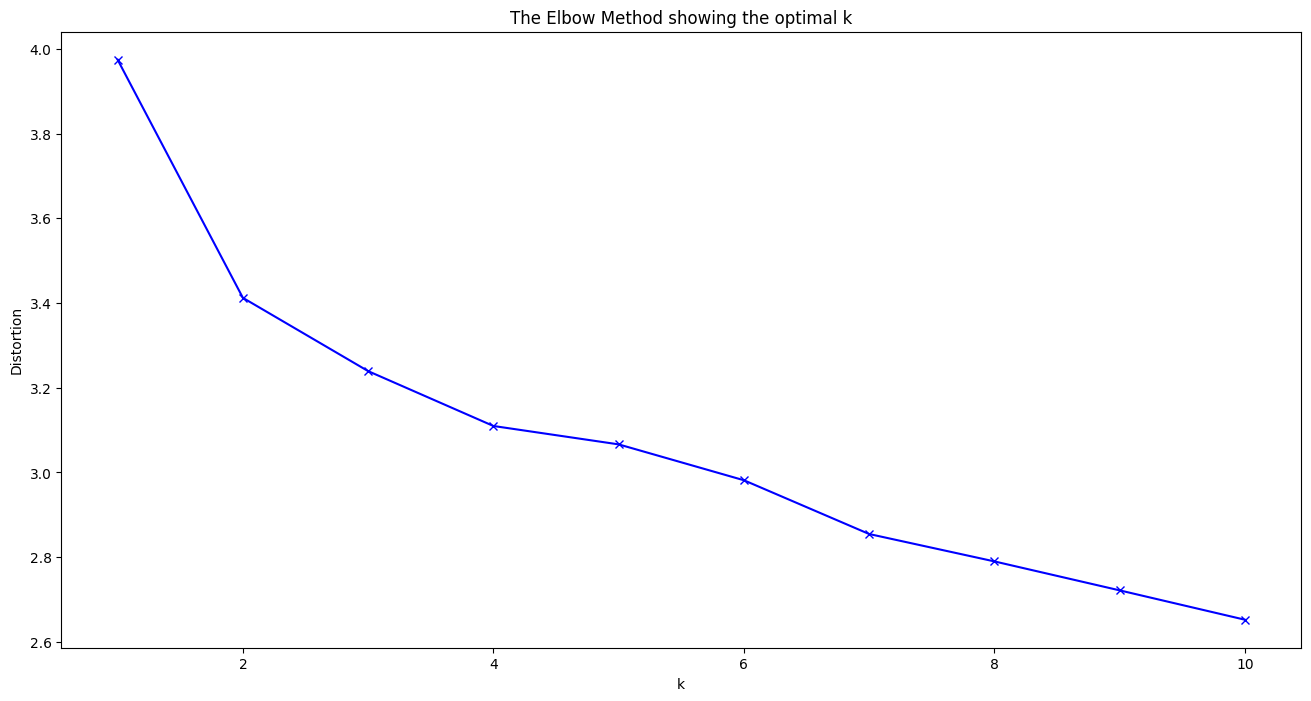

In [27]:
distortions = []
K = range(1, 11)

for k in K:
    kmedoidModel = KMedoids(n_clusters=k, metric='precomputed', random_state=1)
    kmedoidModel.fit(distances2)
    distortions.append(kmedoidModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<span style="color:yellow; font-size:50px">Υποερώτημα 1d</span>

### Το πρόβλημα με την μέτρηση της απόστασης μεταξύ δυο σημείων με συντεταγμένες οι οποίες περιέχουν αριθμούς απο το 0 εως το 10 στις οποίες το 0 δεν είναι το μικρότερο προκαλεί τον αλγόριθμο να βρίσκει σημεία τα οποία δεν θα έπρεπε να είναι κοντά μεταξύ τους, να έχουν πολύ μικρή απόσταση και να εισέρχονται στις ίδιες συστάδες. Αυτό συνέβη αρκετές φορές στον κώδικα μας διότι άμα επιλέξουμε χρήστες που έχουνε κρίνει πολλές ταινίες τότε ενώ περιορίζουμε τους χρήστες πολύ, δεν περιορίζουμε τα στοιχεία. Σε αυτήν την κατάσταση υπάρχει μεγάλη περίπτωση να έχουμε χρήστες που έχουν κρίνει τελείως διαφορετικές ταινίες να έχουν μηδενική απόσταση. Αυτό θα μπορούσε να λυθεί εάν προσθέσουμε μία πολύ μεγάλη τιμη, όπως το numpy.inf που θα μπάινει όταν οι χρήστες δεν έχουν κανένα κοινό στοιχειο. 

<span style="color:red; font-size:60px">Αλγοριθμοι Παραγωγης Συστασεων με Χρηση Νευρωνικων Δικτυων</span>



<span style="color:blue; font-size:50px">Ερώτημα 2</span>

<span style="color:cyan; font-size:40px">Δημιουργια μετρικης Jaccard</span>

In [28]:
def jaccard_distance(u, v):
    #επιστρεφει index μονο των αξιολογησεων
    u_set = set(i for i, e in enumerate(u) if e != 0)
    v_set = set(i for i, e in enumerate(v) if e != 0)

    #βρισκω τομη και ενωση
    intersection = u_set.intersection(v_set)
    union = u_set.union(v_set)

    #υπολογιζω και επιστρεφω την μετρικη
    metric = 1 -  (len(intersection) / len(union))

    return metric


<span style="color:cyan; font-size:40px">Δημιουργια τετραγωνικου πινακα αποστασεων</span>

In [29]:
num_users = len(df_users_movies)
distances_matrix = np.zeros((num_users, num_users))

for i in range(num_users):
    for j in range(i+1, num_users): 
        user_i_ratings = df_users_movies.iloc[i].values
        user_j_ratings = df_users_movies.iloc[j].values
        
        distance_ij = jaccard_distance(user_i_ratings, user_j_ratings)
        
        distances_matrix[i, j] = distance_ij
        distances_matrix[j, i] = distance_ij 

print(distances_matrix)


[[0.         0.98482111 0.99417334 ... 0.98894396 0.93557099 0.89349701]
 [0.98482111 0.         0.99019171 ... 0.98683592 0.9571231  0.9772973 ]
 [0.99417334 0.99019171 0.         ... 0.99666825 0.99272397 0.99604317]
 ...
 [0.98894396 0.98683592 0.99666825 ... 0.         0.98062954 0.99248403]
 [0.93557099 0.9571231  0.99272397 ... 0.98062954 0.         0.87079789]
 [0.89349701 0.9772973  0.99604317 ... 0.99248403 0.87079789 0.        ]]


<span style="color:cyan; font-size:40px">Ελαχιστη και μεγιστη τιμη</span>

In [30]:
masked_distances_matrix = np.ma.masked_equal(distances_matrix, 0.0, copy=False)
print(f"{colors.GREEN}max distance: {colors.BOLD_GREEN+str(masked_distances_matrix.max())}")
print(f"{colors.GREEN}min distance: {colors.BOLD_GREEN}{masked_distances_matrix.min():.4f}")

max distance: 1.0
min distance: 0.6570


<span style="color:cyan; font-size:40px">K-means με αποσταση jaccard(1-10 clusters)</span>

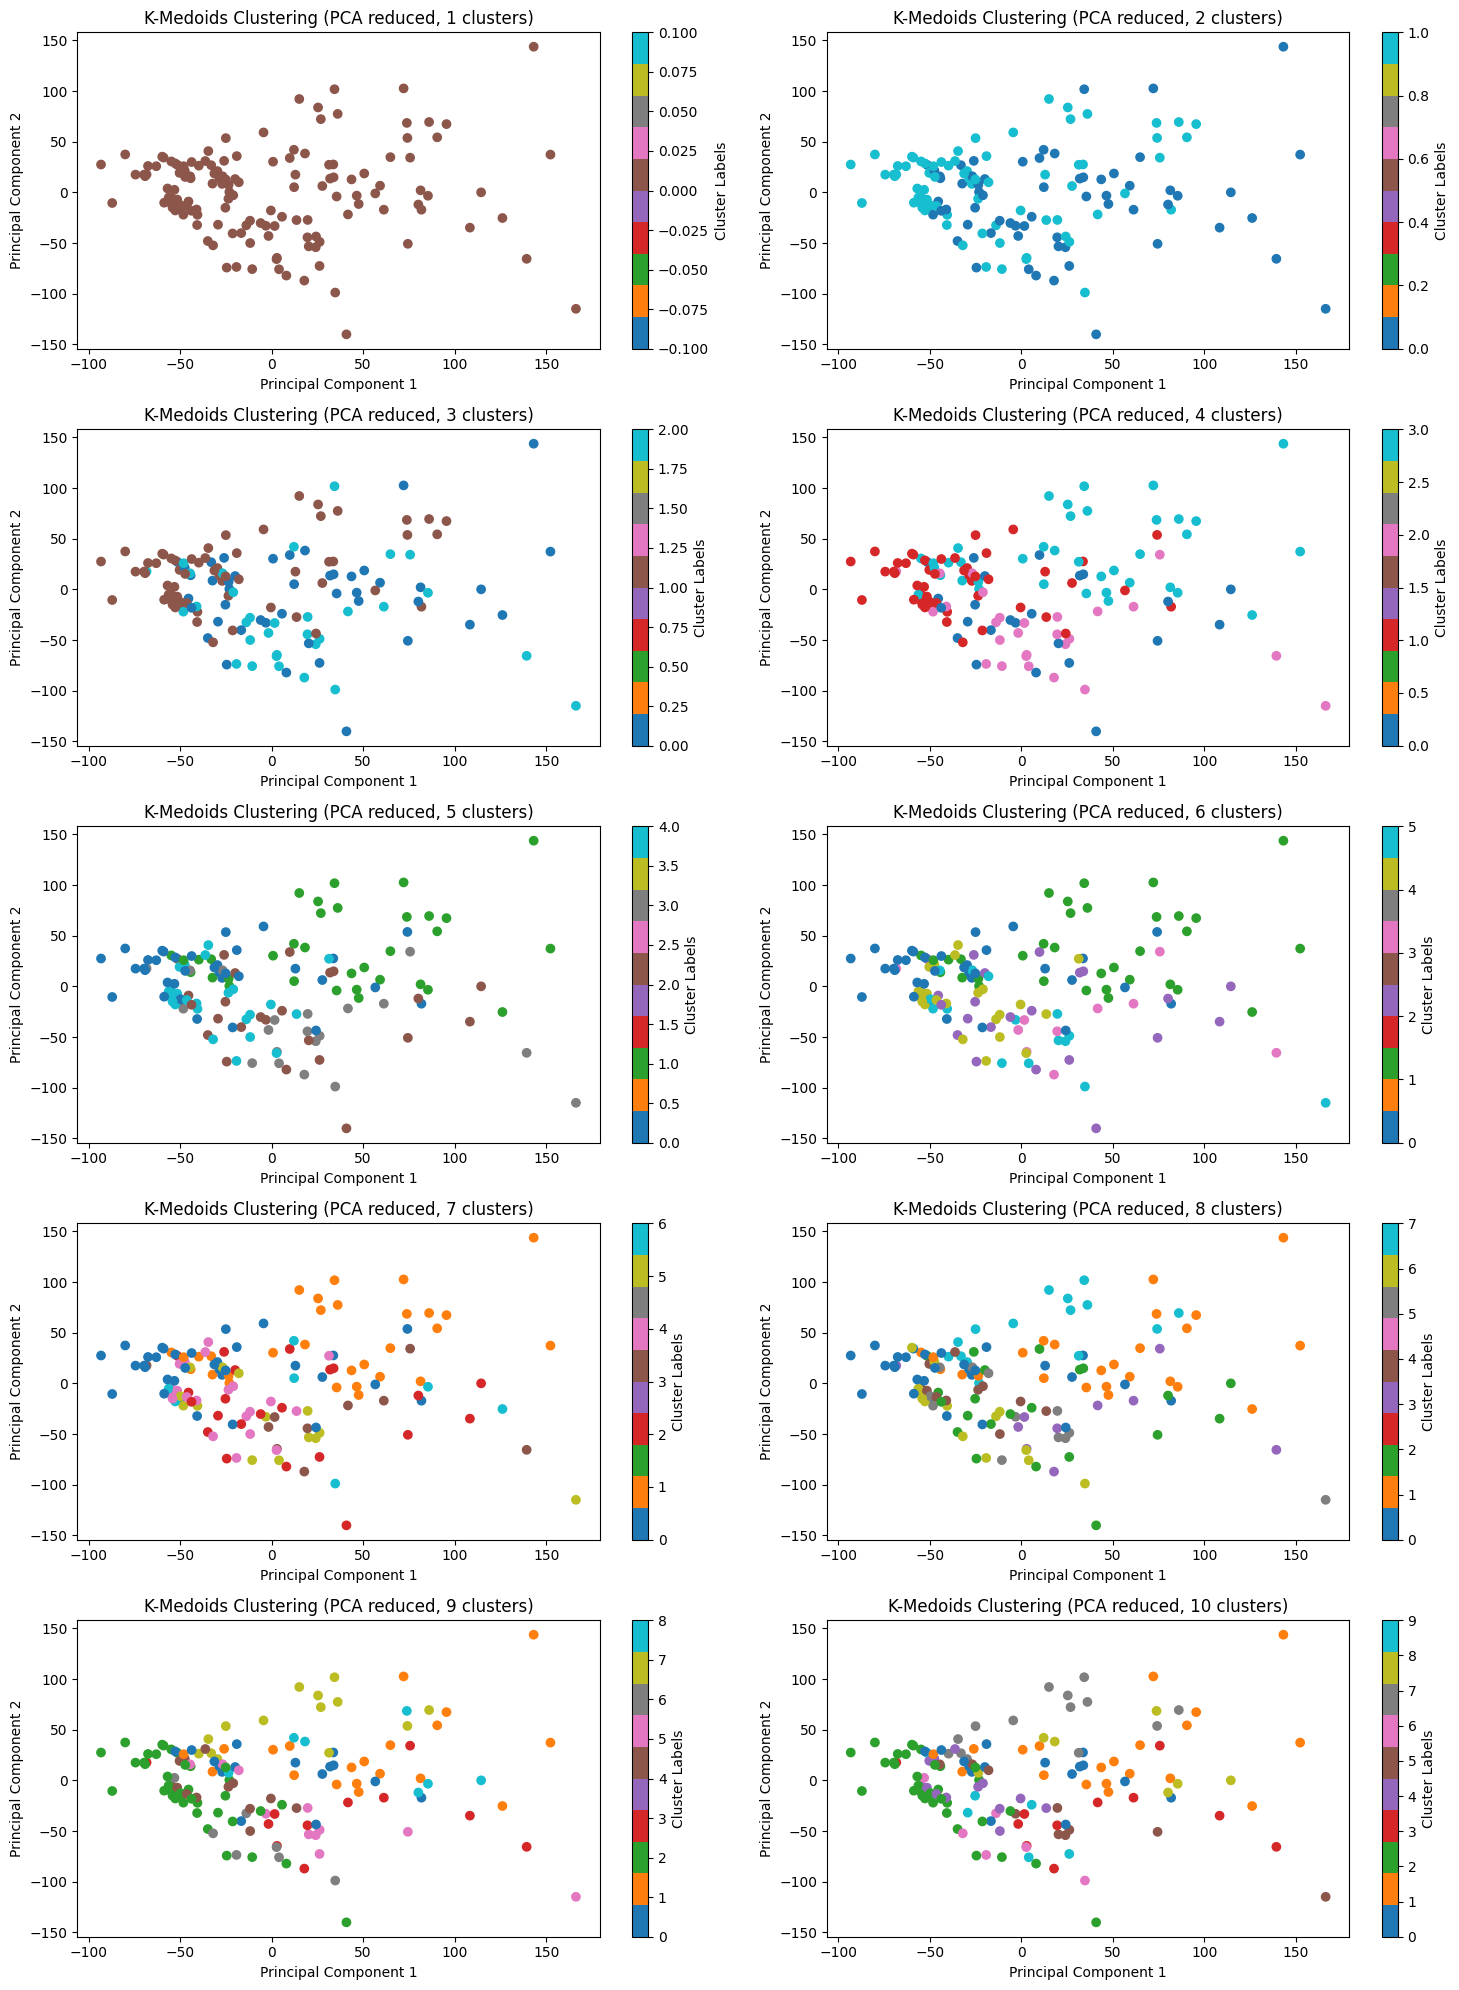

In [31]:
#Ιδιο με τα παραπανω απλα με τις αποστασεις jaccard
pca = PCA(n_components=2)
data_pca = pca.fit_transform(df_users_movies)

fig, axs = plt.subplots(5, 2, figsize=(15, 20))

for i in range(1, 11):
    kmedoids = KMedoids(n_clusters=i, metric='precomputed', random_state=1)
    kmedoids.fit(distances_matrix)
    clusters = kmedoids.labels_
    
    scatter = axs[(i-1) // 2, (i-1) % 2].scatter(data_pca[:, 0], data_pca[:, 1], c=clusters, cmap='tab10')
    
    cbar = fig.colorbar(scatter, ax=axs[(i-1) // 2, (i-1) % 2])
    cbar.set_label('Cluster Labels')
    
    axs[(i-1) // 2, (i-1) % 2].set_title('K-Medoids Clustering (PCA reduced, ' + str(i) + ' clusters)')
    axs[(i-1) // 2, (i-1) % 2].set_xlabel('Principal Component 1')
    axs[(i-1) // 2, (i-1) % 2].set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

<span style="color:cyan; font-size:40px">Elbow μεθοδος για να δουμε τον ιδανικο αριθμο clusters</span>

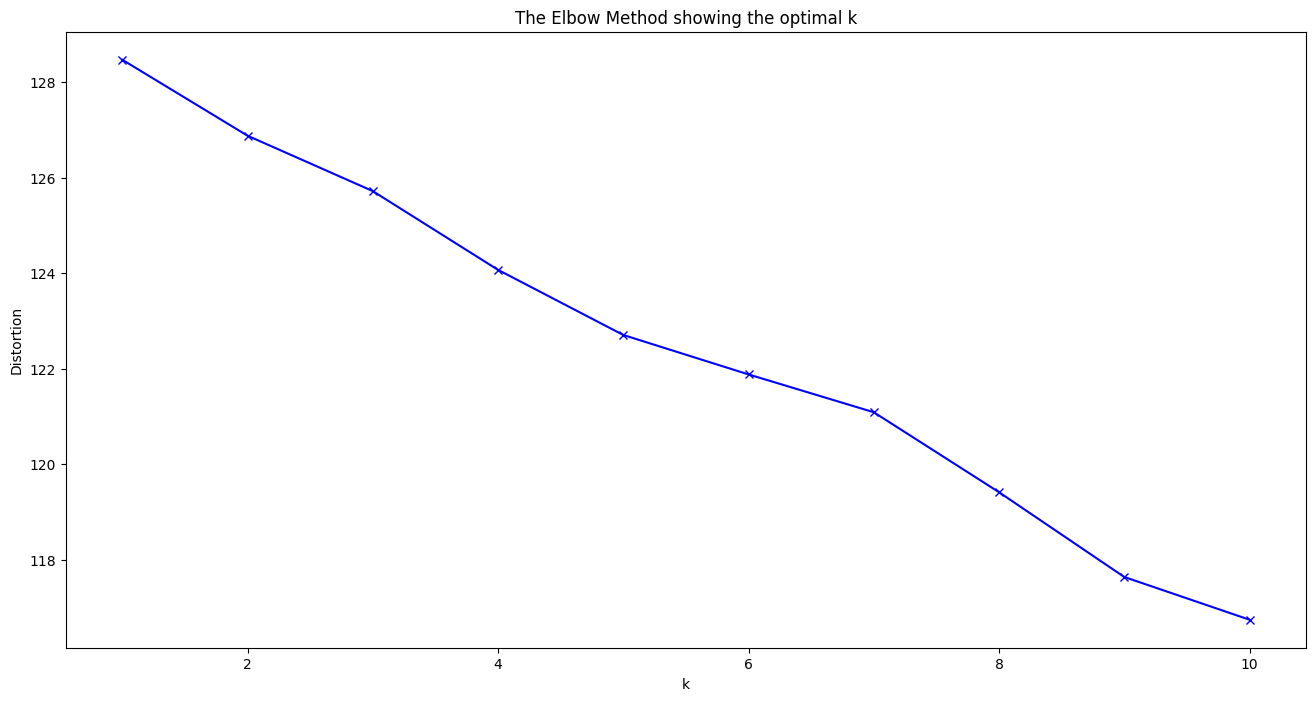

In [32]:
distortions = []
K = range(1, 11)

for k in K:
    kmedoidModel = KMedoids(n_clusters=k, metric='precomputed', random_state=1)
    kmedoidModel.fit(distances_matrix)
    distortions.append(kmedoidModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<span style="color:yellow; font-size:50px">Υποερώτημα 2a</span>

### απαντηση

<span style="color:yellow; font-size:50px">Υποερώτημα 2b</span>

<span style="color:cyan; font-size:40px">Εδω φτιαχνουμε τα feature και label array (X και Y) που θα δωσουμε για train/test</span>

In [33]:
#Βρισκω τον αριθμο των clusters που εχω
num_clusters = max(clusters) + 1
#Κανω την διαδικασια για καθε cluster
for cluster_index in range(num_clusters):
    #Παιρνω τα indexes του τωρινου cluster 
    cluster_indices = np.where(clusters == cluster_index)[0]
    #Κραταω το 90% των κοντινοτερων neighbors (το k μου)
    num_neighbors_to_keep = int((len(cluster_indices) - 1) * 0.9)
    print(f"\n{colors.BOLD_RED}CLUSTER {cluster_index} -- TOTAL USERS {str(num_neighbors_to_keep)+colors.END}")
    #Φτιαχνω τον πινακα μου που θα χρησιμοποιηθει ως features
    empty_array = []
    #Φτιαχνω τον πινακα μου που θα χρησιμοποιηθει ως labels
    labels_list = []

    #Για καθε user στο συγκεκριμενο cluster
    for i in range(num_neighbors_to_keep):
        print(f"{colors.BOLD_BLUE}USER {i}{colors.END}")
        #Παιρνω τις αποστασεις του συγκεκριμενου user απο τους υπολοιπους στο ιδιο cluster
        user_distances = distances_matrix[cluster_indices[i], cluster_indices]
        #τους κανω ενα sort για να παρω τους πιο κοντινους αργοτερα
        sorted_indices = np.argsort(user_distances)
        sorted_user_indices = cluster_indices[sorted_indices]

        #Διωχνω τον κοντινοτερο γειτονα (εχει αποσταση 0 γιατι ειναι με τον εαυτο του οποτε δεν το θελουμε)
        top_neighbors_indices = sorted_user_indices[1:num_neighbors_to_keep + 1]
        row_array = []

        #Για καθε γειτονα του συγκεκριμενου user
        for neighbor_idx in top_neighbors_indices:
            #Παιρνω το rating vector του γειτονα
            neighbor_rating_vector = df_users_movies.iloc[neighbor_idx].values
            #Το φερνω στο shape που χρειαζομαι
            neighbor_rating_vector_transposed = neighbor_rating_vector.reshape(-1, 1)
            #Παιρνω την αποσταση μεταξυ τους
            distance = distances_matrix[cluster_indices[i], neighbor_idx]
            print(f"{colors.YELLOW}ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID {colors.BOLD_MAGENTA}{neighbor_idx}{colors.YELLOW} ΜΕ ΑΠΟΣΤΑΣΗ {colors.BOLD_MAGENTA}{distance:.4f}{colors.YELLOW} ΚΑΙ SIZE {colors.BOLD_MAGENTA}{neighbor_rating_vector.size}{colors.YELLOW} ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ {colors.BOLD_MAGENTA}{neighbor_rating_vector[-5:]}{colors.YELLOW}")        
            row_array.append(neighbor_rating_vector_transposed)
        
        #Λιστα με τα labels
        labels_list.append(neighbor_rating_vector_transposed)
        #Λιστα με τα features
        empty_array.append(np.hstack(row_array))  

    #Τελικη μετατροπη πινακων
    features_array = np.vstack(empty_array)
    #Ravel() γιατι πρεπει να ειναι 1d για το νευρωνικο
    labels_array = np.vstack(labels_list).ravel()
    #Φτιαχνω δυναμικα τα ονοματα των μεταβλητων
    globals()[f'cluster{cluster_index+1}_features_array'] = features_array
    globals()[f'cluster{cluster_index+1}_labels_array'] = labels_array
    print(f"{colors.GREEN}Shape of cluster {cluster_index+1} features array: {colors.BOLD_GREEN+str(features_array.shape)}")


CLUSTER 0 -- TOTAL USERS 13
USER 0
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 70 ΜΕ ΑΠΟΣΤΑΣΗ 0.8737 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 109 ΜΕ ΑΠΟΣΤΑΣΗ 0.9170 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 60 ΜΕ ΑΠΟΣΤΑΣΗ 0.9233 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 115 ΜΕ ΑΠΟΣΤΑΣΗ 0.9258 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 56 ΜΕ ΑΠΟΣΤΑΣΗ 0.9261 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 41 ΜΕ ΑΠΟΣΤΑΣΗ 0.9349 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 138 ΜΕ ΑΠΟΣΤΑΣΗ 0.9356 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 108 ΜΕ ΑΠΟΣΤΑΣΗ 0.9554 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VECTOR ΤΟΥ USER ΜΕ ID 30 ΜΕ ΑΠΟΣΤΑΣΗ 0.9609 ΚΑΙ SIZE 74571 ΤΟ ΟΠΟΙΟ ΤΕΛΕΙΩΝΕΙ ΣΕ [0 0 0 0 0]
ΠΡΟΣΘΕΤΩ ΤΟ VEC

<span style="color:yellow; font-size:50px">Υποερώτημα 2c-2d</span>

In [34]:
train_accuracy = []
test_accuracy = []
train_mae = []
test_mae = []

#Δημιουργω νευρωνικο το εκπαιδευω και το δοκιμαζω για καθε αριθμο cluster
for i in range(1, 11):
    X = globals()["cluster{}_features_array".format(i)]
    y = globals()["cluster{}_labels_array".format(i)]

    #Χωριζω τα δεδομενα σε train/test 90/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

    #Multilayer Perceptron Classifier
    clf = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(8, 4), max_iter=1000, random_state=41)

    #Το κανω Train
    clf.fit(X_train, y_train)

    #Υπολογιζω το training accuracy
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)

    #Υπολογιζω το test accuracy
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)

    #Υπολογιζω το training MAE
    train_mae.append(mean_absolute_error(y_train, train_pred))

    #Υπολογιζω το test MAE
    test_mae.append(mean_absolute_error(y_test, test_pred))

#Εκτυπωση αποτελεσματων σε table
results_table = np.array([train_accuracy, test_accuracy, train_mae, test_mae])
results_table = results_table.T
results_df = pd.DataFrame(results_table, columns=['Train Accuracy', 'Test Accuracy', 'Train MAE', 'Test MAE'])
print(results_df)

c:\Users\Trelobill\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


   Train Accuracy  Test Accuracy  Train MAE  Test MAE
0        0.982816       0.983031   0.043771  0.043283
1        0.997324       0.997373   0.005535  0.005616
2        0.999446       0.999347   0.000608  0.000693
3        0.989899       0.990419   0.013003  0.012859
4        0.998519       0.998452   0.001979  0.002085
5        0.994198       0.993831   0.009130  0.009605
6        0.982206       0.982299   0.040338  0.044319
7        0.999504       0.999573   0.000500  0.000427
8        0.982741       0.984109   0.038993  0.036833
9        0.984049       0.984311   0.034717  0.034899


In [35]:
train_accuracy = []
test_accuracy = []
train_mae = []
test_mae = []

#Δημιουργω νευρωνικο το εκπαιδευω και το δοκιμαζω για καθε αριθμο cluster
for i in range(1, 11):
    X = globals()["cluster{}_features_array".format(i)]
    y = globals()["cluster{}_labels_array".format(i)]

    #Χωριζω τα δεδομενα σε train/test 90/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

    #Multilayer Perceptron Classifier
    clf = MLPClassifier(solver='adam', hidden_layer_sizes=(8, 4), max_iter=400, random_state=41)

    #Το κανω Train
    clf.fit(X_train, y_train)

    #Υπολογιζω το training accuracy
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)

    #Υπολογιζω το test accuracy
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)

    #Υπολογιζω το training MAE
    train_mae.append(mean_absolute_error(y_train, train_pred))

    #Υπολογιζω το test MAE
    test_mae.append(mean_absolute_error(y_test, test_pred))

#Εκτυπωση αποτελεσματων σε table
results_table = np.array([train_accuracy, test_accuracy, train_mae, test_mae])
results_table = results_table.T
results_df = pd.DataFrame(results_table, columns=['Train Accuracy', 'Test Accuracy', 'Train MAE', 'Test MAE'])
print(results_df)

   Train Accuracy  Test Accuracy  Train MAE  Test MAE
0        1.000000       1.000000   0.000000  0.000000
1        1.000000       1.000000   0.000000  0.000000
2        1.000000       1.000000   0.000000  0.000000
3        1.000000       1.000000   0.000000  0.000000
4        1.000000       1.000000   0.000000  0.000000
5        0.998907       0.998843   0.003259  0.003034
6        0.998175       0.998156   0.001825  0.001844
7        1.000000       1.000000   0.000000  0.000000
8        0.997109       0.997229   0.002891  0.002771
9        0.997791       0.998089   0.002209  0.001911


In [36]:
train_accuracy = []
test_accuracy = []
train_mae = []
test_mae = []

#Δημιουργω νευρωνικο το εκπαιδευω και το δοκιμαζω για καθε αριθμο cluster
for i in range(1, 11):
    X = globals()["cluster{}_features_array".format(i)]
    y = globals()["cluster{}_labels_array".format(i)]

    #Χωριζω τα δεδομενα σε train/test 90/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

    #Multilayer Perceptron Classifier
    clf = MLPClassifier(solver='adam', hidden_layer_sizes=(8, 4), max_iter=600, random_state=41)

    #Το κανω Train
    clf.fit(X_train, y_train)

    #Υπολογιζω το training accuracy
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)

    #Υπολογιζω το test accuracy
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)

    #Υπολογιζω το training MAE
    train_mae.append(mean_absolute_error(y_train, train_pred))

    #Υπολογιζω το test MAE
    test_mae.append(mean_absolute_error(y_test, test_pred))

#Εκτυπωση αποτελεσματων σε table
results_table = np.array([train_accuracy, test_accuracy, train_mae, test_mae])
results_table = results_table.T
results_df = pd.DataFrame(results_table, columns=['Train Accuracy', 'Test Accuracy', 'Train MAE', 'Test MAE'])
print(results_df)

   Train Accuracy  Test Accuracy  Train MAE  Test MAE
0        1.000000       1.000000   0.000000  0.000000
1        1.000000       1.000000   0.000000  0.000000
2        1.000000       1.000000   0.000000  0.000000
3        1.000000       1.000000   0.000000  0.000000
4        1.000000       1.000000   0.000000  0.000000
5        0.998907       0.998843   0.003259  0.003034
6        0.998175       0.998156   0.001825  0.001844
7        1.000000       1.000000   0.000000  0.000000
8        0.997109       0.997229   0.002891  0.002771
9        0.997791       0.998089   0.002209  0.001911


In [37]:
train_accuracy = []
test_accuracy = []
train_mae = []
test_mae = []

#Δημιουργω νευρωνικο το εκπαιδευω και το δοκιμαζω για καθε αριθμο cluster
for i in range(1, 11):
    X = globals()["cluster{}_features_array".format(i)]
    y = globals()["cluster{}_labels_array".format(i)]

    #Χωριζω τα δεδομενα σε train/test 90/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

    #Multilayer Perceptron Classifier
    clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(8, 4), max_iter=400, random_state=41)

    #Το κανω Train
    clf.fit(X_train, y_train)

    #Υπολογιζω το training accuracy
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)

    #Υπολογιζω το test accuracy
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)

    #Υπολογιζω το training MAE
    train_mae.append(mean_absolute_error(y_train, train_pred))

    #Υπολογιζω το test MAE
    test_mae.append(mean_absolute_error(y_test, test_pred))

#Εκτυπωση αποτελεσματων σε table
results_table = np.array([train_accuracy, test_accuracy, train_mae, test_mae])
results_table = results_table.T
results_df = pd.DataFrame(results_table, columns=['Train Accuracy', 'Test Accuracy', 'Train MAE', 'Test MAE'])
print(results_df)

   Train Accuracy  Test Accuracy  Train MAE  Test MAE
0        0.995836       0.995585   0.004177  0.004436
1        0.999519       0.999495   0.000481  0.000505
2        0.999001       0.998932   0.001326  0.001448
3        0.998053       0.998033   0.002260  0.002354
4        0.998185       0.998123   0.002113  0.002121
5        0.986312       0.986137   0.021147  0.021104
6        0.980600       0.980656   0.041743  0.045761
7        0.999503       0.999403   0.000497  0.000597
8        0.984578       0.985785   0.032182  0.029949
9        0.984049       0.984311   0.033030  0.033223


In [38]:
train_accuracy = []
test_accuracy = []
train_mae = []
test_mae = []

#Δημιουργω νευρωνικο το εκπαιδευω και το δοκιμαζω για καθε αριθμο cluster
for i in range(1, 11):
    X = globals()["cluster{}_features_array".format(i)]
    y = globals()["cluster{}_labels_array".format(i)]

    #Χωριζω τα δεδομενα σε train/test 90/10
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

    #Multilayer Perceptron Classifier
    clf = MLPClassifier(solver='sgd', hidden_layer_sizes=(8, 4), max_iter=600, random_state=41)

    #Το κανω Train
    clf.fit(X_train, y_train)

    #Υπολογιζω το training accuracy
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    train_accuracy.append(train_acc)

    #Υπολογιζω το test accuracy
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    test_accuracy.append(test_acc)

    #Υπολογιζω το training MAE
    train_mae.append(mean_absolute_error(y_train, train_pred))

    #Υπολογιζω το test MAE
    test_mae.append(mean_absolute_error(y_test, test_pred))

#Εκτυπωση αποτελεσματων σε table
results_table = np.array([train_accuracy, test_accuracy, train_mae, test_mae])
results_table = results_table.T
results_df = pd.DataFrame(results_table, columns=['Train Accuracy', 'Test Accuracy', 'Train MAE', 'Test MAE'])
print(results_df)

   Train Accuracy  Test Accuracy  Train MAE  Test MAE
0        0.995836       0.995585   0.004177  0.004436
1        0.999519       0.999495   0.000481  0.000505
2        0.999001       0.998932   0.001326  0.001448
3        0.998053       0.998033   0.002260  0.002354
4        0.998185       0.998123   0.002113  0.002121
5        0.986312       0.986137   0.021147  0.021104
6        0.980600       0.980656   0.041743  0.045761
7        0.999503       0.999403   0.000497  0.000597
8        0.984578       0.985785   0.032182  0.029949
9        0.984049       0.984311   0.033030  0.033223
